# Asymmetry test series

For the paper, for each measurement, generate plots of how the asymmetry measurement depends on 
1) Signal-to-noise
2) Pixel scale
3) PSF FWHM

Keeping all other parameters constant. For constant values, choose:

* Pixel scale: 0.1" (about 180pc at z=0.1, 300pc at z=0.2)
* PSF FWHM: 0.8" (good ground-based seeing)
* Noise level: 25 mag/arcsec$^2$ (pretty deep imaging)


#### Imports

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from galaxy_generator import get_galaxy_rng_vals, get_augmentation_rng_vals, simulate_perfect_galaxy, add_source_to_image, sky_noise
from asymmetry import get_asymmetry, fourier_deconvolve
from astropy.convolution import Gaussian2DKernel
from astropy.stats import sigma_clipped_stats, gaussian_fwhm_to_sigma

seed = 19
perfect_pxscale = 0.1
convolve_nyquist = True

## Generating a galaxy

We use a single galaxy for all the plots here, generated with the same set of parameters. 

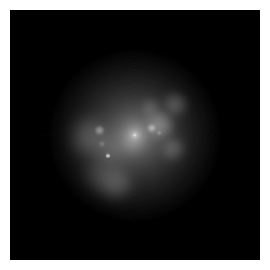

In [2]:
params = get_galaxy_rng_vals(1, perfect_pxscale=perfect_pxscale, seed=seed)[0]
img_perfect, galaxy_dict, r_pet = simulate_perfect_galaxy(pxscale=perfect_pxscale,  **params)

plt.imshow(-2.5*np.log10(img_perfect/perfect_pxscale**2) + 33, vmin=17, vmax=27, cmap='gray_r')
plt.axis('off');

In [36]:
def augment(pxscale, psf_fwhm, sky_mag):
    
    img_lowres, out_dict, r_pet = simulate_perfect_galaxy(pxscale=pxscale, **params)
    img_psf = add_source_to_image(**out_dict, psf_fwhm=psf_fwhm, pxscale=pxscale, psf_method='astropy')
    img_noisy, sky_flux = sky_noise(img_psf, sky_mag=sky_mag, pixel_scale=pxscale, rms_noise=True)
    return img_noisy, img_lowres

In [37]:
# plt.imshow(-2.5*np.log10(img_noisy/perfect_pxscale**2) + 33, vmin=17, vmax=27, cmap='gray_r')

Test deconvolution:

In [38]:
from numpy import fft
from asymmetry import _fit_snr

def fourier_deconvolve2(img, psf, noise, pxscale, convolve_nyquist=False):

    # img = np.pad(img, (20,20))
    # psf = np.pad(psf, (20,20))

    # Transform the image and the PSF
    img_fft = fft.fft2(img)
    psf_fft = fft.fft2(fft.ifftshift(psf))
    
    noise_fft = np.median(np.abs(img_fft))
    # noise_fft = noise * img_fft.shape[0] 

    # Get the SNR
    snr = fit_snr2(img_fft, noise_fft)

    # If True, convolve down to Nyquist frequency
    if convolve_nyquist:
        nyquist_psf = Gaussian2DKernel(2, x_size=img.shape[1], y_size=img.shape[0])
        nyquist_fft = fft.fft2(fft.ifftshift(nyquist_psf))
    else:
        nyquist_fft = 1
        
    # Deconvolve
    H_sq = np.power((1 + 1/snr), 2) / np.power((np.abs(psf_fft) + 1/snr), 2)
    H = np.sqrt(H_sq)
    
    # H = (nyquist_fft + 1/snr) / (psf_fft + 1/snr)
    img_corr = img_fft * H

    # Do an inverse transform
    img_deconv = np.real(fft.ifft2(img_corr))

    # img_deconv = img_deconv[20:-20, 20:-20]
    return img_deconv

In [39]:
from scipy.interpolate import griddata
def fit_snr2(img_fft, noise_fft, snr_thresh=3, quant_thresh=0.98):
    """Given an FFT of an image and a noise level, estimate SNR(omega)
    by interpolating high SNR regions and setting high-frequency SNR to 1k less than SNR max.
    """
    

    # Calculate from the image SNR
    snr = np.abs(img_fft) / noise_fft
    snr_min = np.log10(np.max(snr)) - 4  # Minimum SNR is 100000 times dimmer than the center
    
    # Only look at one quarter of the array (FFT is reflected along x and y)
    xc = int(img_fft.shape[0]/2)
    snr_corner = snr[:xc, :xc]
    
    # Image x, y arrays as placeholders
    xs = np.arange(xc+1)
    XS, YS = np.meshgrid(xs, xs)
    
    # Choose indices where SNR is high 
    snr_lim = np.quantile(snr_corner, quant_thresh)
    snr_lim = np.max([snr_lim, snr_thresh])
    good_ids = np.nonzero(snr_corner > snr_lim)
    good_log_snr = np.log10(snr_corner[good_ids])
    
    # Select regions dominated by noise and set their SNR to snr_min
    noise_ids = np.nonzero(snr_corner < 1)   
    noise_log_snr = snr_min*np.ones(len(noise_ids[0]))

    # SNR array to interpolate
    log_snr = np.concatenate((good_log_snr, noise_log_snr))
    snr_ids = np.hstack((good_ids, noise_ids))
    snr_ids = (snr_ids[0], snr_ids[1])
    xs = XS[snr_ids]
    ys = YS[snr_ids]

    # Add a low SNR at highest frequency edges to help interpolation
    boundaries = np.arange(xc+1)
    xs = np.concatenate((xs, np.ones_like(boundaries)*(xc+1), boundaries))
    ys = np.concatenate((ys, boundaries, np.ones_like(boundaries)*(xc+1)))
    log_snr = np.concatenate((log_snr, snr_min*np.ones_like(boundaries), snr_min*np.ones_like(boundaries)))

    # Interpolate
    snr_grid = griddata((xs, ys), log_snr, (XS, YS), method='linear')
    

    # Expand the grid (corner) back to the original shape by doubling in X and Y
    j = -1 
    k = -1 if (snr.shape[0] % 2 == 1) else -2
    fit_snr = np.ones_like(snr)
    fit_snr[:xc,:xc] = snr_grid[:j, :j]
    fit_snr[xc:,:xc] = snr_grid[k::-1, :j]
    fit_snr[:xc,xc:] = snr_grid[:j, k::-1]
    fit_snr[xc:,xc:] = snr_grid[k::-1, k::-1]
    
    # Undo the log
    fit_snr = np.power(10, fit_snr)

    # Rewrite the good SNR regions with real values
    good_ids = np.nonzero(snr > snr_lim)
    fit_snr[good_ids] = snr[good_ids]
    
    return fit_snr

In [40]:
pxscale = 0.2
psf_fwhm = 3
psf_std = psf_fwhm * gaussian_fwhm_to_sigma 
sky_mag = 30

img_noisy, img_lowres = augment(pxscale, psf_fwhm, sky_mag)
# psf_nyquiest = Gaussian2DKernel(
psf = Gaussian2DKernel(psf_std/pxscale, x_size=img_noisy.shape[1], y_size=img_noisy.shape[0]).array
_, bgsd, _ = sigma_clipped_stats(img_noisy)
bgsd = 1.6

img_deconv = fourier_deconvolve2(img_noisy, psf, bgsd, 0.3, False)

In [41]:
# fig, axs = plt.subplots(1,3,figsize=(7.53, 2.5))

# axs[0].imshow(((img_deconv)/pxscale**2), vmin=0, vmax=5e5, cmap='gray')
# axs[1].imshow(((img_noisy)/pxscale**2), vmin=0, vmax=5e5, cmap='gray')
# axs[2].imshow(((img_lowres)/pxscale**2) , vmin=0, vmax=5e5, cmap='gray')

# for ax in axs:
#     ax.axis('off')
    
# plt.subplots_adjust(wspace=0.01)

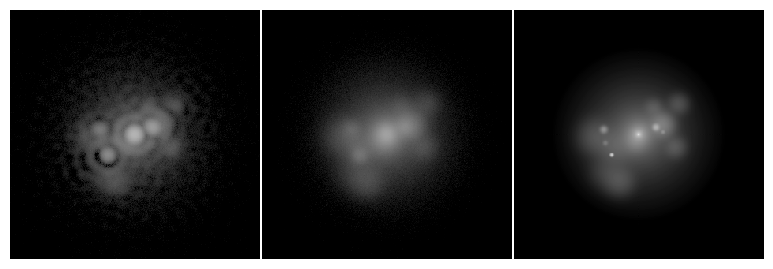

In [42]:
fig, axs = plt.subplots(1,3,figsize=(7.53, 2.5))

axs[0].imshow(-2.5*np.log10(np.abs(img_deconv)/pxscale**2) + 33, vmin=17, vmax=27, cmap='gray_r')
axs[1].imshow(-2.5*np.log10(np.abs(img_noisy)/pxscale**2) + 33, vmin=17, vmax=27, cmap='gray_r')
axs[2].imshow(-2.5*np.log10(np.abs(img_lowres)/pxscale**2) + 33, vmin=17, vmax=27, cmap='gray_r')

for ax in axs:
    ax.axis('off')
    
plt.subplots_adjust(wspace=0.01)

## Calculating asymmetry

Calculate 4 different asymmetry measurements:

* CAS |A|
* Corrected CAS |A|
* $A^2$
* Fourier $A^2$

For a given galaxy

In [56]:
def get_asymmetry_measurements(img_real, img_obs, pxscale, psf, bgsd):
    
    #### Calculate real galaxy asymmertry
    a_cas_real = get_asymmetry(img_real, ap_frac*r_pet/perfect_pxscale, a_type='cas', sky_type='annulus', bg_corr='residual', sky_annulus=[1.5, 3])
    a_sq_real = get_asymmetry(img_real, ap_frac*r_pet/perfect_pxscale, a_type='squared', sky_type='annulus', bg_corr='full', sky_annulus=[1.5, 3])
    
    #### Calculate noisy asymmetries
    a_cas, _ = get_asymmetry(img_obs, ap_frac*r_pet/pxscale, a_type='cas', sky_type='annulus', bg_corr='residual', sky_annulus=[1.5, 3])
    a_cas_corr, _ = get_asymmetry(img_obs, ap_frac*r_pet/pxscale, a_type='cas_corr', sky_type='annulus', bg_corr='residual', sky_annulus=[1.5, 3])
    a_sq, _ = get_asymmetry(img_obs, ap_frac*r_pet/pxscale, a_type='squared', sky_type='annulus', bg_corr='full', sky_annulus=[1.5, 3])
    
    # Fourier asymmetry
    # Estimate background noise
    img_deconv = fourier_deconvolve(img_obs, psf, bgsd, convolve_nyquist=convolve_nyquist)
    a_fourier, _ = get_asymmetry(img_deconv, ap_frac*r_pet/pxscale, a_type='squared', sky_type='annulus', bg_corr='full', sky_annulus=[1.5, 3])
 
    ##### Store output
    output = {
        'a_cas_real' : a_cas_real, 'a_sq_real' : a_sq_real, 
        'a_cas' : a_cas, 'a_cas_cor' : a_cas_corr, 
        'a_sq' : a_sq, 'a_fourier' : a_fourier
    }
    
    return output, img_deconv
    

## CAS asymmetry

We use the same set-up as for all other tests, but for these test series, only test on a single galaxy. Make a realization with one seed so we know it's always the same if the kernel is refreshed.

In [30]:
img_fft = fft.fft2(img_lowres)
noisy_fft = fft.fft2(img_noisy)

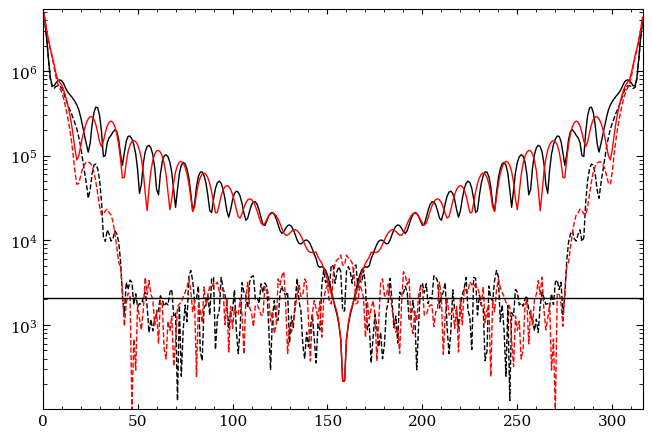

In [43]:
plt.figure(figsize=(6,4))

plt.plot(np.abs(img_fft[0]), 'k-', lw=1)
plt.plot(np.abs(noisy_fft[0]), 'k--', lw=1)

plt.plot(np.abs(img_fft[:,0]), 'r-', lw=1)
plt.plot(np.abs(noisy_fft[:,0]), 'r--', lw=1)

noise = np.median(np.abs(noisy_fft))
plt.axhline(noise, color='k', lw=1)


plt.yscale('log')